In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use("fivethirtyeight")
%matplotlib inline
import sqlite3 as sql

In [2]:
conn = sql.connect("instacart.db")
c = conn.cursor()

In [14]:
orders_by_dow_q = "SELECT order_dow, COUNT(*) FROM orders GROUP BY order_dow"
c.execute(orders_by_dow_q)
orders_dow = c.fetchall()
print(orders_dow)

[(0, 72971), (1, 71582), (2, 56404), (3, 53205), (4, 51551), (5, 54903), (6, 54156)]


In [15]:
day_week = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
orders_dow = [(day_week[tup[0]], tup[1]) for tup in orders_dow]
orders_dow

[('Mon', 72971),
 ('Tue', 71582),
 ('Wed', 56404),
 ('Thu', 53205),
 ('Fri', 51551),
 ('Sat', 54903),
 ('Sun', 54156)]

Here we investigate how the number of orders vary day the day of the week. The day of the week variable is a number from 0 to 6 and it is not clear exactly what these correspond to exactly. In the dataset, days 0 and 1 have the most orders so it is possible as these are days on the weekend. The other 5 days seem to have approximately equal numbers of orders.

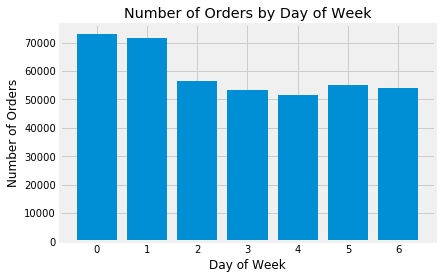

In [21]:
plt.bar(range(len(orders_dow)), [tup[1] for tup in orders_dow])
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.title("Number of Orders by Day of Week")

In [23]:
orders_by_hour = "SELECT order_hour_of_day, COUNT(*) FROM orders GROUP BY Order_hour_of_day"
c.execute(orders_by_hour)
orders_hour = c.fetchall()
print(orders_hour)

[(0, 2771), (1, 1479), (2, 883), (3, 666), (4, 686), (5, 1200), (6, 3709), (7, 10990), (8, 21066), (9, 31282), (10, 34825), (11, 34425), (12, 32920), (13, 33794), (14, 34568), (15, 34528), (16, 32970), (17, 27736), (18, 22375), (19, 17099), (20, 12758), (21, 9402), (22, 7619), (23, 5021)]


This is a histogram of the number of orders placed by hour of the day. There are very few orders placed between midnight and 5 AM. The majority of orders are placed between 9 AM and 6 PM. 

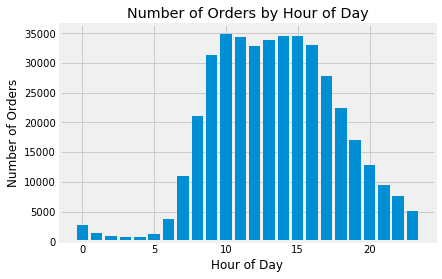

In [25]:
plt.bar(range(len(orders_hour)), [tup[1] for tup in orders_hour])
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.title("Number of Orders by Hour of Day")

In [26]:
between_orders_q = "SELECT days_since_prior_order FROM orders"
c.execute(between_orders_q)
between_orders = c.fetchall()

This histogram below shows the distribution of the variable that measures days between orders. There is a spike at 7 days which lines up with the idea that many people shop for groceries on a weekly basis. There is also a peak at 30 days which needs to be investigated in more detail.

In [32]:
between_orders = [time[0] for time in between_orders if time[0] is not None]

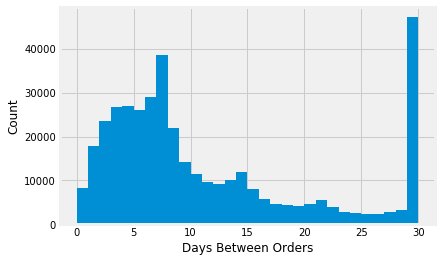

In [35]:
plt.hist(between_orders, bins=30)
plt.xlabel("Days Between Orders")
plt.ylabel("Count")

Make a query that looks at the 20 most popular items based on the number of times it is ordered. It appears that fruit and vegetable items make up the majority of these most popular items. Organic milk and garlic are the non fruit/vegetable items in this list.

In [52]:
most_popular = "SELECT o.count, p.product_name, p.product_id FROM \
                (SELECT COUNT(*) AS count, product_id FROM \
                order_products \
                GROUP BY product_id) AS o \
                LEFT JOIN products p \
                ON o.product_id = p.product_id\
                ORDER BY o.count DESC\
                LIMIT 20"
c.execute(most_popular)

In [53]:
most_popular = c.fetchall()
most_popular

[(58231, 'Banana', 24852),
 (45699, 'Bag of Organic Bananas', 13176),
 (32203, 'Organic Strawberries', 21137),
 (29380, 'Organic Baby Spinach', 21903),
 (25958, 'Organic Hass Avocado', 47209),
 (21642, 'Organic Avocado', 47766),
 (18581, 'Large Lemon', 47626),
 (17399, 'Limes', 26209),
 (17217, 'Strawberries', 16797),
 (16468, 'Organic Whole Milk', 27845),
 (16205, 'Organic Raspberries', 27966),
 (13355, 'Organic Yellow Onion', 22935),
 (13137, 'Organic Garlic', 24964),
 (12420, 'Organic Zucchini', 45007),
 (12022, 'Organic Blueberries', 39275),
 (11890, 'Cucumber Kirby', 49683),
 (10632, 'Organic Fuji Apple', 28204),
 (10258, 'Apple Honeycrisp Organic', 8277),
 (10249, 'Organic Grape Tomatoes', 40706),
 (10200, 'Organic Lemon', 5876)]

In [35]:
def most_popular_hour(start, end):
    """Find the 20 most popular products within a given time frame."""
    most_popular = """SELECT o.count, p.product_name, p.product_id FROM 
                (SELECT COUNT(*) AS count, product_id FROM 
                order_products o 
                LEFT JOIN orders s 
                ON o.order_id = s.order_id 
                WHERE s.order_hour_of_day BETWEEN %d AND %d 
                GROUP BY product_id) AS o 
                LEFT JOIN products p 
                ON o.product_id = p.product_id 
                ORDER BY o.count DESC
                LIMIT 20""" % (start, end)
    c.execute(most_popular)
    popular_prods = c.fetchall()
    return popular_prods

It does not appear that the most popular items within a given hour or longer timeframe differ very much from the overall items that are popular. This was done to investigate if there were potential differences in which items were ordered frequently based on the time of day an order was placed. A number of time ranges were investigated and it did not seem that there was anything particularly interesting based on this.

In [82]:
most_popular_hour(8, 9)

[(7870, 'Banana', 24852),
 (6163, 'Bag of Organic Bananas', 13176),
 (4284, 'Organic Strawberries', 21137),
 (3617, 'Organic Baby Spinach', 21903),
 (3251, 'Organic Hass Avocado', 47209),
 (2704, 'Organic Avocado', 47766),
 (2375, 'Strawberries', 16797),
 (2346, 'Organic Whole Milk', 27845),
 (2338, 'Large Lemon', 47626),
 (2178, 'Organic Raspberries', 27966),
 (2129, 'Limes', 26209),
 (1617, 'Organic Fuji Apple', 28204),
 (1585, 'Organic Yellow Onion', 22935),
 (1576, 'Organic Blueberries', 39275),
 (1468, 'Organic Garlic', 24964),
 (1468, 'Organic Zucchini', 45007),
 (1465, 'Apple Honeycrisp Organic', 8277),
 (1448, 'Organic Half & Half', 49235),
 (1439, 'Seedless Red Grapes', 4920),
 (1411, 'Cucumber Kirby', 49683)]

In [38]:
most_popular_hour(21, 22)

[(2598, 'Banana', 24852),
 (2136, 'Bag of Organic Bananas', 13176),
 (1658, 'Organic Strawberries', 21137),
 (1419, 'Organic Baby Spinach', 21903),
 (1144, 'Organic Hass Avocado', 47209),
 (1010, 'Organic Avocado', 47766),
 (886, 'Organic Whole Milk', 27845),
 (827, 'Organic Raspberries', 27966),
 (821, 'Strawberries', 16797),
 (808, 'Large Lemon', 47626),
 (710, 'Limes', 26209),
 (616, 'Organic Blueberries', 39275),
 (566, 'Organic Zucchini', 45007),
 (564, 'Organic Garlic', 24964),
 (555, 'Cucumber Kirby', 49683),
 (545, 'Organic Grape Tomatoes', 40706),
 (527, 'Organic Yellow Onion', 22935),
 (490, 'Seedless Red Grapes', 4920),
 (484, 'Carrots', 17794),
 (480, 'Organic Baby Carrots', 42265)]

In [83]:
def most_popular_day(day):
    """Find the 20 most popular products on a given day."""
    most_popular = """SELECT o.count, p.product_name, p.product_id FROM 
                (SELECT COUNT(*) AS count, product_id FROM 
                order_products o 
                LEFT JOIN orders s 
                ON o.order_id = s.order_id 
                WHERE s.order_dow = %d 
                GROUP BY product_id) AS o 
                LEFT JOIN products p 
                ON o.product_id = p.product_id 
                ORDER BY o.count DESC
                LIMIT 20""" % (day)
    c.execute(most_popular)
    popular_prods = c.fetchall()
    return popular_prods

In [86]:
most_popular_day(3)

[(6587, 'Banana', 24852),
 (5491, 'Bag of Organic Bananas', 13176),
 (3643, 'Organic Strawberries', 21137),
 (3106, 'Organic Baby Spinach', 21903),
 (2983, 'Organic Hass Avocado', 47209),
 (2357, 'Organic Avocado', 47766),
 (2021, 'Organic Whole Milk', 27845),
 (1973, 'Strawberries', 16797),
 (1971, 'Large Lemon', 47626),
 (1889, 'Organic Raspberries', 27966),
 (1804, 'Limes', 26209),
 (1444, 'Organic Yellow Onion', 22935),
 (1414, 'Organic Blueberries', 39275),
 (1371, 'Organic Garlic', 24964),
 (1361, 'Organic Zucchini', 45007),
 (1241, 'Cucumber Kirby', 49683),
 (1201, 'Organic Fuji Apple', 28204),
 (1199, 'Seedless Red Grapes', 4920),
 (1187, 'Sparkling Water Grapefruit', 44632),
 (1182, 'Organic Half & Half', 49235)]

This query below aims to look at the items that are reordered the most frequently

In [134]:
reorder_q =  """SELECT o.product_id, o.prop_reorder, o.count, p.product_name FROM
            (SELECT COUNT(*) as count, AVG(reordered) as prop_reorder, product_id 
            FROM order_products
            GROUP BY product_id) as o 
            LEFT JOIN products p
            ON o.product_id = p.product_id
            WHERE o.count > 150
            ORDER BY o.prop_reorder DESC
            LIMIT 20"""
c.execute(reorder_q)
top_reorder = c.fetchall()
top_reorder

[(27402,
  0.896969696969697,
  165,
  'Healthy Kids Organic Vanilla Nutritional Shake'),
 (34197, 0.8850698174006445, 931, 'Goat Milk'),
 (32911,
  0.8831168831168831,
  154,
  'Organic Sensitivity Infant Formula with Iron'),
 (9292, 0.8782816229116945, 419, 'Half And Half Ultra Pasteurized'),
 (22537, 0.8742857142857143, 175, 'Hearty Nine Grain Bread'),
 (29500, 0.8717948717948718, 195, 'Hard-Boiled Eggs'),
 (43394, 0.8695286195286195, 1188, 'Organic Lactose Free Whole Milk'),
 (47943, 0.8691099476439791, 191, 'Unsweetened Terere Yerba Mate'),
 (2748, 0.8671532846715329, 685, 'Organic Reduced Fat Omega-3 Milk'),
 (29447, 0.8622710622710623, 2730, 'Milk, Organic, Vitamin D'),
 (38689, 0.859434360489658, 4738, 'Organic Reduced Fat Milk'),
 (14466, 0.8535031847133758, 157, 'Oat Chocolate Chip Coconut Whenever Bars'),
 (6066, 0.8525641025641025, 156, "Mini Moo's Real Cream Half & Half"),
 (23383, 0.8509316770186336, 322, 'Super Natural Organic Whole Milk'),
 (117, 0.8506375227686703, 549

In [154]:
order_num_q = """SELECT COUNT(*) as n, order_number
                 FROM orders
                 GROUP BY order_number
                 ORDER BY order_number
              """
c.execute(order_num_q)
order_num = c.fetchall()

There are a total of 25,000 unique users represented in the orders table. In the dataset, all users made at least 4 orders in the time frame. roughly 25% of these users made 20 or more orders.

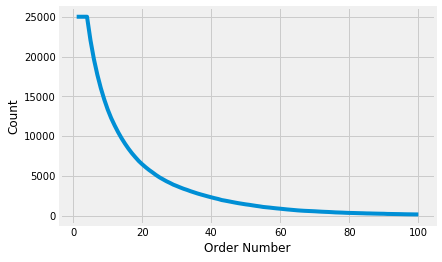

In [158]:
plt.plot([tup[1] for tup in order_num], [tup[0] for tup in order_num])
plt.xlabel("Order Number")
plt.ylabel("Count")

In [161]:
c.execute("SELECT COUNT(DISTINCT user_id) FROM orders")
num_uniq_users = c.fetchall()
print("There are %d distinct users in the orders table." %(num_uniq_users[0][0]))

There are 25000 distinct users in the orders table.


Here we will examine a histogram of the number of products in a given order.

In [162]:
num_prod_order_q = """SELECT MAX(add_to_cart_order) FROM
                    order_products
                    GROUP BY order_id
                   """
c.execute(num_prod_order_q)
num_prod_order = c.fetchall()

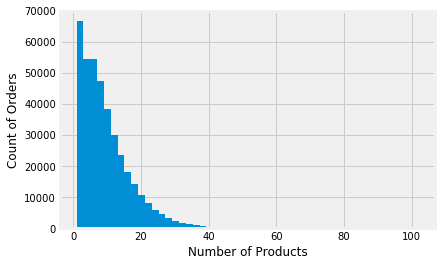

In [167]:
plt.hist([tup[0] for tup in num_prod_order], bins=50)
plt.xlabel("Number of Products")
plt.ylabel("Count of Orders")

Now we have a look at the number of products ordered broken down by each of the departments. The largest category by far is produce which lines up with the earlier observation that fruit and vegetables made up the majority of the most popular individual item types.

In [175]:
dept_pop_q = """SELECT d.department, COUNT(*) as count FROM 
              (SELECT p.department_id FROM
              order_products o LEFT JOIN products p
              ON o.product_id = p.product_id) as j
              LEFT JOIN departments d
              ON j.department_id = d.department_id
              GROUP BY d.department_id
              ORDER BY count DESC
              """
c.execute(dept_pop_q)
dept_pop = c.fetchall()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

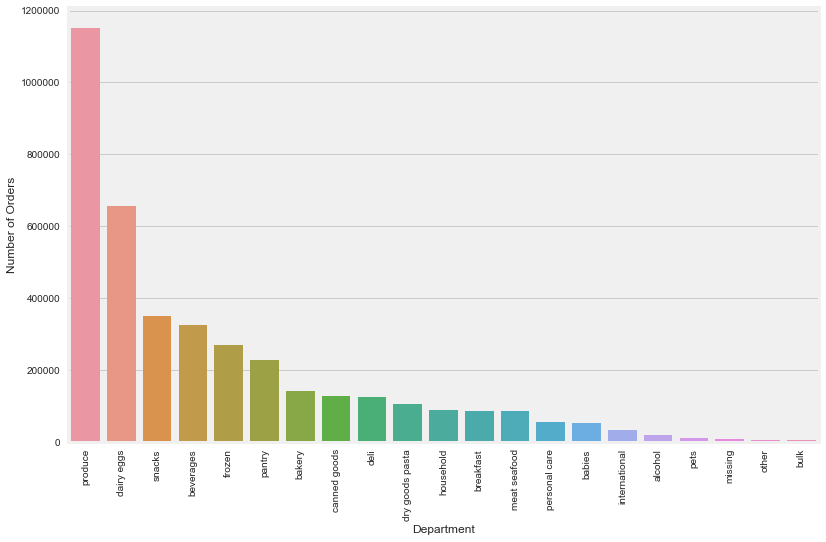

In [181]:
plt.figure(figsize=(12, 8))
sns.barplot([tup[0] for tup in dept_pop], [tup[1] for tup in dept_pop])
plt.xlabel("Department")
plt.ylabel("Number of Orders")
plt.xticks(rotation = "vertical")

In [182]:
aisle_pop_q = """SELECT a.aisle, COUNT(*) as count FROM 
              (SELECT p.aisle_id FROM
              order_products o LEFT JOIN products p
              ON o.product_id = p.product_id) as j
              LEFT JOIN aisles a
              ON j.aisle_id = a.aisle_id
              GROUP BY a.aisle_id
              ORDER BY count DESC
              """
c.execute(aisle_pop_q)
aisles_pop = c.fetchall()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

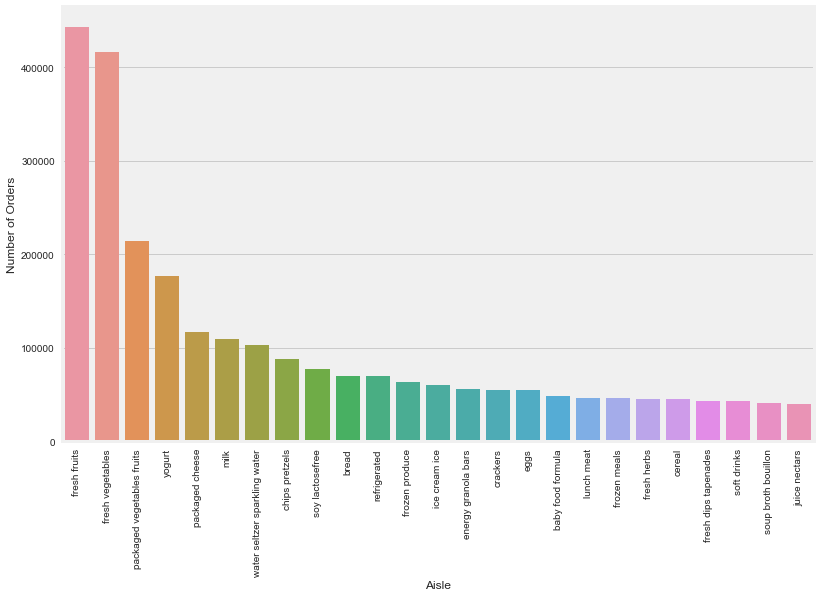

In [184]:
aisles_pop = aisles_pop[:25]
plt.figure(figsize=(12, 8))
sns.barplot([tup[0] for tup in aisles_pop], [tup[1] for tup in aisles_pop])
plt.xlabel("Aisle")
plt.ylabel("Number of Orders")
plt.xticks(rotation = "vertical")

In [186]:
time_between_q = """SELECT order_number, AVG(days_since_prior_order)
                 FROM orders
                 WHERE order_number > 1
                 GROUP BY order_number
                 """
c.execute(time_between_q)
time_between = c.fetchall()

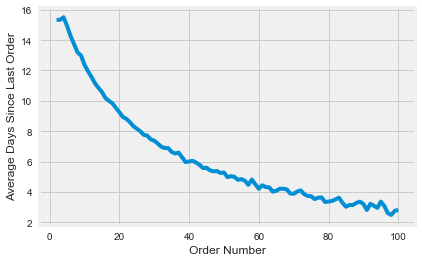

In [190]:
plt.plot([tup[0] for tup in time_between], [tup[1] for tup in time_between])
plt.xlabel("Order Number")
plt.ylabel("Average Days Since Last Order")

In [15]:
aisles_df = pd.read_sql_query("SELECT * from aisles", conn)
aisles_df.drop(["index"], axis=1, inplace=True)
aisles_df.head()
aisles_df.to_csv("aisles.csv", index=False)

In [17]:
dept_df = pd.read_sql_query("SELECT * from departments", conn)
dept_df.drop(["index"], axis=1, inplace=True)
dept_df.head()
dept_df.to_csv("dept.csv", index=False)

In [18]:
prod_df = pd.read_sql_query("SELECT * from products", conn)
prod_df.drop(["index"], axis=1, inplace=True)
prod_df.head()
prod_df.to_csv("prods.csv", index=False)

In [21]:
prods = pd.read_csv("prods.csv", encoding="ISO-8859-1")
prods.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [23]:
ord_df = pd.read_sql_query("SELECT * from orders", conn)
ord_df.head()
ord_df.to_csv("orders.csv", index=False)

In [3]:
ords = pd.read_csv("orders.csv")
ords.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2168274,2,1,2,11,NaN
1,1501582,2,2,5,10,10.0
2,1901567,2,3,1,10,3.0
3,738281,2,4,2,10,8.0
4,1673511,2,5,3,11,8.0


In [28]:
op_df = pd.read_sql_query("SELECT * from order_products", conn)
op_df.head()
op_df.to_csv("order_prods.csv", index=False)

In [29]:
ops = pd.read_csv("order_prods.csv")
ops.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
group_dow_hour = ords.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()

In [5]:
group_dow_hour = group_dow_hour.pivot("order_dow", "order_hour_of_day", "order_number")

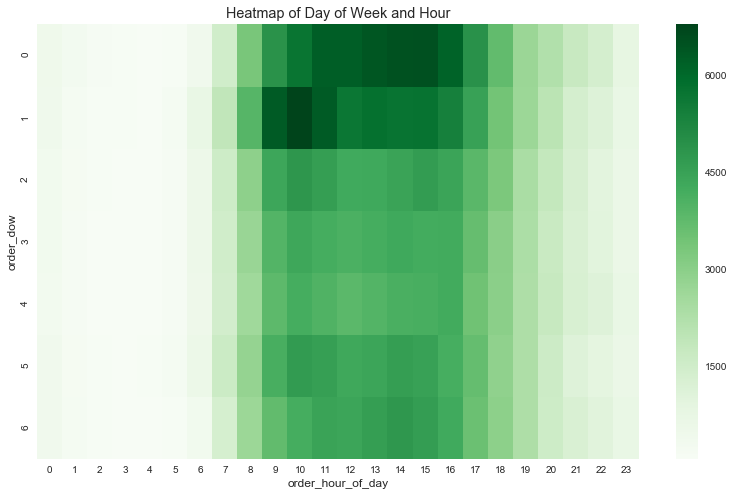

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(group_dow_hour, cmap="Greens")
plt.title("Heatmap of Day of Week and Hour")

25000